In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from scipy.signal import convolve2d


In [4]:
def normalize(matrix):
    normalizedData = (matrix-np.min(matrix))/(np.max(matrix)-np.min(matrix))
    return normalizedData

In [5]:
#Load images

snrImg = []
snrReconstruct = []

rootNoisy = "gr5/Noisy"
noisyImgs = glob.glob(f"{rootNoisy}/*.bmp") + glob.glob(f"{rootNoisy}/*.jpg") 

rootOriginal = "gr5/Original"
originalImgs = glob.glob(f"{rootOriginal}/*.bmp") + glob.glob(f"{rootOriginal}/*.jpg")

originalImgs.sort()
noisyImgs.sort()

In [ ]:
for i in range(len(originalImgs)):
    imgOriginal = cv2.imread(originalImgs[i],0)
    imgNoisy = cv2.imread(noisyImgs[i],0)

    histOrig, bins = np.histogram(imgOriginal.ravel(), bins=256, range=(0, 255))
    histNoise, bins = np.histogram(imgNoisy.ravel(), bins=256, range=(0, 255))

    histNoiseOnly = histNoise - histOrig

    imgNoiseOnly = imgNoisy - imgOriginal


    mean_sq_err = np.mean(imgNoiseOnly**2)
    snr = 10 * np.log10(np.mean(imgOriginal**2) / mean_sq_err)

    variance = np.var(imgNoiseOnly)
    noiseType = ""
    print(variance)
    if variance < 12000:
        noiseType = 'Il rumore è di tipo\n uniforme'
    elif variance >= 12000 and variance < 15000:
        noiseType ='Il rumore è di tipo\n gaussiano'
    elif variance >= 15000:
        noiseType ='Il rumore è di tipo\n impulsivo (sale e pepe)'

    print(snr)
    snrImg.append(snr)
    
    fig, axes = plt.subplots(3,2,figsize=(6,6))
    fig.tight_layout()
    axes[0][0].imshow(imgOriginal, cmap="gray")
    axes[0][0].set_title(f"Immagine originale")

    axes[0][1].hist(imgOriginal.ravel(),256,[0,256])
    axes[0][1].set_title(f"Istogramma immagine originale")

    axes[1][0].imshow(imgNoisy, cmap="gray")
    axes[1][0].set_title(f"Immagine rumorosa")

    axes[1][1].hist(imgNoisy.ravel(),256,[0,256])
    axes[1][1].set_title(f"Istogramma immagine rumorosa")

    axes[2][0].text(0, 0.2, noiseType)
    axes[2][0].set_title(f"Tipo rumore")

    axes[2][1].hist(histNoiseOnly,256,[0,256])
    axes[2][1].set_title(f"Istogramma differenza ")

    plt.show()


In [ ]:
#presa un immagine definisco i tipi di rumore

img = cv2.imread(originalImgs[1],0)
#np.random.seed(42)

#Rumore gaussiano
noise = np.random.normal(size=img.shape)
imgNoisyGauss = img + noise
imgNoisyGauss = cv2.normalize(imgNoisyGauss, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

histOrig, bins = np.histogram(imgOriginal.ravel(), bins=256, range=(0, 255))

histNoise, bins = np.histogram(imgNoisyGauss.ravel(), bins=256, range=(0, 255))

histNoiseOnlyGauss = histNoise - histOrig

#Rumore uniforme
low = 0
high = 255
noise = np.random.uniform(low, high, img.shape)
#noise = np.random.rand(*img.shape) * 255
imgNoisyUni = img + noise
imgNoisyUni = cv2.normalize(imgNoisyUni, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

histNoise, bins = np.histogram(imgNoisyUni.ravel(), bins=256, range=(0, 255))

histNoiseOnlyUnif = histNoise - histOrig

#Rumore sale e pepe
x,y = img.shape
noise = np.random.rand(x,y)*255
salt = noise > 240
pepper = noise < 15
imgNoisySandP = img.copy()
imgNoisySandP[salt] = 255
imgNoisySandP[pepper] = 0
imgNoisySandP = cv2.normalize(imgNoisySandP, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

histNoise, bins = np.histogram(imgNoisySandP.ravel(), bins=256, range=(0, 255))

histNoiseOnlySandP = histNoise - histOrig

#matplot delle immagini con istogrammi
fig, axes = plt.subplots(4,2,figsize=(7,7))
fig.tight_layout()
axes[0][0].imshow(img, cmap="gray")
axes[0][0].set_title(f"Immagine originale")

axes[0][1].hist(imgOriginal.ravel(),256,[0,256])
axes[0][1].set_title(f"Istogramma immagine originale")

axes[1][0].imshow(imgNoisyGauss, cmap="gray")
axes[1][0].set_title(f"Immagine rumorosa gauss")

axes[1][1].hist(histNoiseOnlyGauss,256,[0,256])
axes[1][1].set_title(f"Istogramma rumore gauss")

axes[2][0].imshow(imgNoisyUni, cmap="gray")
axes[2][0].set_title(f"Immagine rumorosa uniforme ")

axes[2][1].hist(histNoiseOnlyUnif,256,[0,256])
axes[2][1].set_title(f"Istogramma rumore uniforme ")

axes[3][0].imshow(imgNoisySandP, cmap="gray")
axes[3][0].set_title(f"Immagine rumorosa sale e pepe ")

axes[3][1].hist(histNoiseOnlySandP,256,[0,256])
axes[3][1].set_title(f"Istogramma rumore sale e pepe ")

plt.show()

In [70]:
def valueCheck(matrix, i, j):
  try:
    return matrix[i][j]
  except IndexError:
    return 0
  
def sigma(a,b):
  if a == b:
    return 1
  return 0


def computeEdEp(x, Y, i, j):
  '''
  Input : X immagine da ripulire, Y Immagine ripulita, ij Posizione, w_e w_s y_val pesi
  
  '''

  #questo è Ed
  #Ed = w_e * X[i][j] * y_val

  #Questi sono Ep
  #Ep += 4 * w_s * y_val
  #result1 = valueCheck(Y, i+1, j) + valueCheck(Y, i-1, j) + valueCheck(Y, i, j+1) + valueCheck(Y, i, j-1)
  #Ep *= result1
  #Sommo Ed ed Ep poiché servono sempre coppia
  #result = Ed+Ep


  Ed = (sigma(x,Y[i][j]))
  Ep = (sigma(Y[i][j],valueCheck(Y, i+1, j)))+(sigma(Y[i][j],valueCheck(Y, i-1, j)))+(sigma(Y[i][j],valueCheck(Y, i, j+1)))+(sigma(Y[i][j],valueCheck(Y, i, j-1)))

  result = Ed+Ep  
  return result

def computeEdEpMatrix(X,Y):
  m, n = np.shape(X)
  ret = np.zeros_like(X).astype(dtype=float)
  for i in range(m):
    for j in range (n):
      ret[i][j] = computeEdEp(X[i][j], Y, i, j)
  return ret


def denoiseImage(X, w_e=-1, w_s=-1, iter=150):
  m, n = np.shape(X)
  Y = np.copy(X)
  #Y = np.zeros_like(X)
  for iteration in range(iter):
    print("",end="\r")
    print(f'Percentage done: {round(((100*iteration)/iter),2)}', end="\r")
    Energy = computeEdEpMatrix(X, Y)
    for i in range(m):
      for j in range (n):
      #Dalla riga 10 dello pseudocodice, scopriamo che i e j non devono essere presi random ma vanno scansionati tutti
      # Dopo aver scansionato, applichiamo l'algoritmo descritto nelle righe 10,11,12, dopo ciò 
      # calcolare E[i,j] quindi applicare il cambiamento se si verifica la condizione
        t= 1 - Y[i][j]        
        if (computeEdEp(t,Y,i,j)<Energy[i][j]):
          Y[i][j]=t

        '''
        log_p_neg = computeEdEp(X, Y, i, j, w_e, w_s, -1)
        log_p_pos = computeEdEp(X, Y, i, j, w_e, w_s, 1)
        if log_p_neg > log_p_pos:
          Y[i][j] = -1
        else:
          Y[i][j] = 1
        '''
  
      
  return Y

In [ ]:
import torch
import torch.nn.functional as F

def energy_function(img, labels, beta):
    # calcolo dell'energia del sistema
    smoothness_energy = beta * (labels - labels.roll(1, dims=1)) ** 2
    smoothness_energy += beta * (labels - labels.roll(1, dims=0)) ** 2
    data_energy = (img - labels) ** 2
    energy = data_energy + smoothness_energy
    return energy.sum()

def denoise_image_icm_bmrf(img, beta=0.05, num_iter=3):
    # trasferimento dell'immagine sulla gpu
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img = torch.from_numpy(img).float().to(device)

    # inizializzazione dell'etichetta
    label = torch.zeros_like(img).to(device)

    for i in range(num_iter):
        #print("", end="\r")
        #print(f"iter:{i}\n", end="\r")
        # calcolo della Laplaciana dell'immagine
        laplacian = F.conv2d(label.unsqueeze(0).unsqueeze(0), 
                             torch.Tensor([[0, 1, 0], [1, 0, -1], [0, -1, 0]]).unsqueeze(0).unsqueeze(0).to(device), 
                             padding=1).cuda()
        
        # ciclo su ogni pixel dell'immagine
        for row in range(img.shape[0]):
            for col in range(img.shape[1]):
                #print(f"row: {row}, col: {col}", end="\r")
                # calcolo dell'energia del sistema per i valori di etichetta 0 e 1
                label[row, col] = 0
                energy_0 = energy_function(img, label, beta)
                label[row, col] = 1
                energy_1 = energy_function(img, label, beta)

                # scelta del valore di etichetta che minimizza l'energia
                if energy_0 < energy_1:
                    label[row, col] = 0
                else:
                    label[row, col] = 1
        
        # esclusione del calcolo del gradiente dalla computazione parallela
        with torch.no_grad():
            # trasferimento della Laplaciana sulla gpu
            laplacian = laplacian.to(device)
            # aggiornamento dell'etichetta
            label -= 0.5 * laplacian.squeeze() / beta
    
    # trasferimento dell'etichetta dall gpu alla cpu e restituzione dell'immagine denoised
    return label.cpu().numpy()


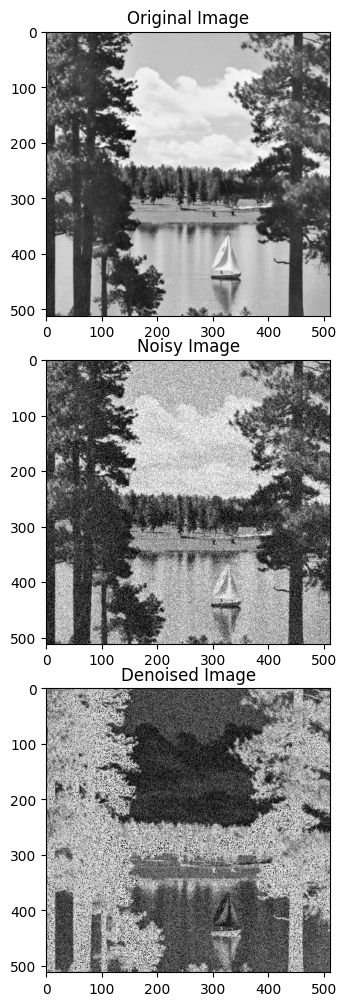

In [74]:
#for i in range(len(originalImgs)):
imgOriginal = cv2.imread(originalImgs[0],0)
imgNoisy = cv2.imread(noisyImgs[0],0)
#imgReconstructed = denoise_image_icm_bmrf(imgNoisy,beta=0.05,num_iter=100)
imgReconstructed = denoiseImage(imgNoisy, iter = 300)
fig, axes = plt.subplots(3,1,figsize=(10,10))
fig.tight_layout()
axes[0].imshow(imgOriginal,cmap="gray")
axes[0].set_title('Original Image')
axes[1].imshow(imgNoisy,cmap="gray")
axes[1].set_title('Noisy Image')
axes[2].imshow(imgReconstructed, cmap="gray")
axes[2].set_title('Denoised Image')
plt.show()

        

In [ ]:
#import pickle
#with open('imgReconstructed.pkl', 'wb') as pickle_file:
#    pickle.dump(imgReconstructed, pickle_file)

#with open('imgReconstructedManual.pkl', 'wb') as pickle_file:
#    pickle.dump(imgReconstructedManual, pickle_file)

In [ ]:
#import os
#os.system("shutdown /s")

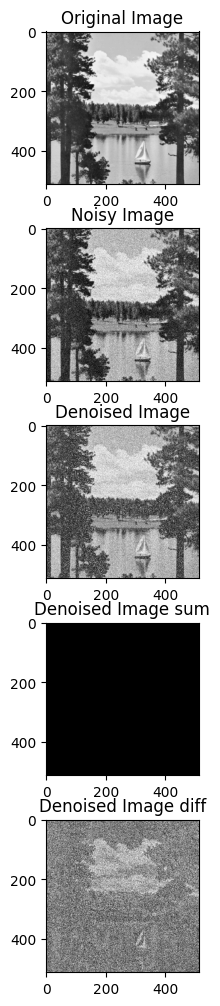

[255 173 233   1  85 255   3 239  83 103  65 193 195 235 227  87 211  93
  61 101 233 239 207 113  65 221 235  57 165  25 209 161  57 211 199 239
 199 111 199  35 139 143  47 161 245  21  25  29 253 151 125  65 217  13
  67 127  35 237 181 225  29 215 137  39   9 169 137 121 105 165  65 147
  21 115 255 189  59  33  87 255 207 227  41 119  75 187  79 105 211 255
  55 161  25  73  37  77 157 103  19 181 135  45 167 149 239 151 199  99
 133 159 107 145 129 141 111 111 133  41   7 197  61  57  11  91 121  41
  95 123 191 137  47  17 229 187  67  57  85 115  41 101 135  45 133 147
 141 203 161 171 251 137  63  55  65  51 247 227 125  95  95 113 109  79
 133  67  35 141  65  63 115 253 145 237  17  77 143 145  63  47  83 217
 221  59  11  51  53  45 181 141  69 155 171 159 103  67   9 109  83  11
  15 135 203  37 193 101 173  25 249  57   3 145  51 219 155 143 163 101
 171  97 225 225 135 205 253 135  45 167  15 191 181  99  31  63 137  33
 197 109 239 137 117  11  37  85 127 185 105 145  8

In [73]:
#imgOriginal = cv2.imread(originalImgs[1],0)
#imgNoisy = cv2.imread(noisyImgs[1],0)
#imgReconstructed = denoise_image_icm_bmrf(imgNoisy)
fig, axes = plt.subplots(5,1,figsize=(10,10))
fig.tight_layout()
axes[0].imshow(imgOriginal,cmap="gray")
axes[0].set_title('Original Image')
axes[1].imshow(imgNoisy,cmap="gray")
axes[1].set_title('Noisy Image')
axes[2].imshow((-imgReconstructed), cmap="gray")
axes[2].set_title('Denoised Image')
axes[3].imshow((imgNoisy+imgReconstructed), cmap="gray")
axes[3].set_title('Denoised Image sum')
axes[4].imshow((imgNoisy-imgReconstructed), cmap="gray")
axes[4].set_title('Denoised Image diff')
plt.show()
a =(imgNoisy-imgReconstructed)
for i in a:
    print(i)